In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [3]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

In [4]:
def process_video():
    left_elbow_index = 7
    left_shoulder_index = 5
    left_hip_index = 11
    right_elbow_index = 8
    right_shoulder_index = 6
    right_hip_index = 12
    left_ankle_x = []
    right_ankle_x = []
    last_left_ankle_x = None
    stride_lengths = []
    left_ankle_x_positions = []
    pelvic_tilt_angles = []
    left_elbow_flaring_angles = []
    right_elbow_flaring_angles = []
    vertical_upright_angles = []

    cap = cv2.VideoCapture("sample1.mp4")

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        # Reshape image
        img = frame.copy()
        img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192, 192)
        input_image = tf.cast(img, dtype=tf.float32)

        # Setup input and output
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        # Make predictions
        interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
        interpreter.invoke()
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

        # Calculate stride length
        left_ankle_x = keypoints_with_scores[0, 0, 15, 0]
        right_ankle_x = keypoints_with_scores[0, 0, 16, 0]
        left_ankle_x_positions.append(left_ankle_x)

        # Calculate pelvic tilt
        current_pelvic_tilt = calculate_pelvic_tilt(keypoints_with_scores)
        pelvic_tilt_angles.append(current_pelvic_tilt)

        # Calculate elbow flaring angles
        left_elbow_index = 7
        left_shoulder_index = 5
        left_hip_index = 11
        right_elbow_index = 8
        right_shoulder_index = 6
        right_hip_index = 12

        elbow_flaring = calculate_elbow_flaring(keypoints_with_scores, left_elbow_index, left_shoulder_index, left_hip_index, right_elbow_index, right_shoulder_index, right_hip_index)
        left_elbow_flaring_angles.append(elbow_flaring[0])
        right_elbow_flaring_angles.append(elbow_flaring[1])

        current_vertical_upright_angle = calculate_vertical_upright_angle(
            keypoints_with_scores, left_shoulder_index, right_shoulder_index
        )
        vertical_upright_angles.append(current_vertical_upright_angle)
        # Calculate stride length
        if left_ankle_x is not None:
            if last_left_ankle_x is not None:
                stride_length = abs(right_ankle_x - last_left_ankle_x)
                stride_lengths.append(stride_length)        
            last_left_ankle_x = left_ankle_x

        # Rendering 
        draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
        draw_keypoints(frame, keypoints_with_scores, 0.4)

        cv2.imshow('MoveNet Lightning', frame)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    visualize_stride_pattern(stride_lengths, left_ankle_x_positions)
    visualize_pelvic_tilt(pelvic_tilt_angles)
    visualize_elbow_flaring(left_elbow_flaring_angles, right_elbow_flaring_angles)
    visualize_vertical_upright_angle(vertical_upright_angles)
    
    
    


In [5]:

def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [6]:
def calculate_pelvic_tilt(keypoints_with_scores):
    # Define the indices for the relevant keypoints (left hip, right hip, and spine)
    left_hip_index = 11  # Adjust the keypoint indices based on your model
    right_hip_index = 12
    spine_index = 8

    # Extract the y-coordinates of the left hip, right hip, and spine keypoints
    left_hip_y = keypoints_with_scores[0,0, left_hip_index, 0]  
    right_hip_y = keypoints_with_scores[0,0, right_hip_index, 0] 
    spine_y = keypoints_with_scores[0,0, spine_index, 0] 

    if None not in [left_hip_y, right_hip_y, spine_y]:
        # Calculate pelvic tilt angle (in degrees)
        pelvic_tilt_angle = np.arctan2(right_hip_y - left_hip_y, spine_y - 0.5) * (180.0 / np.pi)
        return pelvic_tilt_angle
    else:
        return None


In [7]:
def calculate_vertical_upright_angle(keypoints, left_shoulder_index, right_shoulder_index):
    # Extract the y-coordinates of the left and right shoulder keypoints
    left_shoulder_y = keypoints[0, 0, left_shoulder_index, 0]
    right_shoulder_y = keypoints[0, 0, right_shoulder_index, 0]

    # Calculate the vertical upright angle (in degrees)
    vertical_upright_angle = np.arctan2(right_shoulder_y - left_shoulder_y, 1)  # Assuming the vertical axis is (0,1)
    vertical_upright_angle = np.degrees(vertical_upright_angle)

    return vertical_upright_angle
def visualize_vertical_upright_angle(vertical_upright_angles):
    time_axis = np.arange(len(vertical_upright_angles))

    # Plot the vertical upright angles over time
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, vertical_upright_angles)
    plt.xlabel('Frame')
    plt.ylabel('Vertical Upright Angle (degrees)')
    plt.title('Vertical Upright Angle Over Time')

    # Calculate and display the maximum vertical upright angle
    max_upright_angle = max(vertical_upright_angles)
    max_frame = vertical_upright_angles.index(max_upright_angle)
    plt.axvline(max_frame, color='red', linestyle='--', label=f'Max Angle: {max_upright_angle:.2f} degrees at frame {max_frame}')
    
    plt.legend()
    plt.show()


In [8]:
def visualize_stride_pattern(stride_lengths, left_ankle_x_positions):
    # Calculate statistics
    avg_stride = np.mean(stride_lengths)
    # Calculate stride rate (strides per second)
    time_axis = np.arange(len(left_ankle_x_positions))
    # Plot the left ankle x-coordinate positions (stride pattern)
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, left_ankle_x_positions)
    plt.xlabel('Frame')
    plt.ylabel('X-coordinate of Left Ankle')
    plt.title('Left Ankle Stride Pattern')
    plt.show()
    print(f"Average Stride Length: {avg_stride:.2f} units (e.g., pixels)")


In [9]:
def visualize_pelvic_tilt(pelvic_tilt_angles):
    time_axis = range(len(pelvic_tilt_angles))
    
    # Plot pelvic tilt angles over time
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, pelvic_tilt_angles, label='Pelvic Tilt Angle')
    plt.xlabel('Frame')
    plt.ylabel('Pelvic Tilt Angle (degrees)')
    plt.title('Pelvic Tilt Over Time')
    
    # Calculate and display the average pelvic tilt angle
    avg_pelvic_tilt = sum(pelvic_tilt_angles) / len(pelvic_tilt_angles)
    plt.axhline(avg_pelvic_tilt, color='red', linestyle='--', label=f'Avg Pelvic Tilt: {avg_pelvic_tilt:.2f} degrees')
    
    plt.legend()
    plt.show()


In [10]:
def calculate_angles(point1, point2, point3):
    vector1 = point1 - point2
    vector2 = point3 - point2
    dot_product = np.dot(vector1, vector2)
    magnitude_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    cosine_theta = dot_product / magnitude_product
    angle_rad = np.arccos(np.clip(cosine_theta, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)
    return angle_deg


In [11]:
def calculate_knee_hip_angle(keypoints_with_scores):
    hip_index = 11
    knee_index = 13
    ankle_index = 15

    # Initialize lists to store hip and knee angles
    hip_angles = []
    knee_angles = []

    # Iterate through the frames and calculate angles
    for i in range(len(keypoints_positions_array)):  
        hip_position = keypoints_positions_array[i][hip_index]
        knee_position = keypoints_positions_array[i][knee_index]
        ankle_position = keypoints_positions_array[i][ankle_index]

        # Calculate hip angle (angle at the hip joint)
        hip_angle = calculate_angles(knee_position, hip_position, ankle_position)
        hip_angles.append(hip_angle)

        # Calculate knee angle (angle at the knee joint)
        knee_angle = calculate_angles(hip_position, knee_position, ankle_position)
        knee_angles.append(knee_angle)

    # Create a time axis for plotting
    time_axis = np.arange(len(hip_angles))

    # Plot hip and knee angles
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, hip_angles, label='Hip Angle')
    plt.plot(time_axis, knee_angles, label='Knee Angle')
    plt.xlabel('Frame')
    plt.ylabel('Angle (degrees)')
    plt.title('Hip and Knee Angles Over Time')
    plt.legend()
    plt.show()


In [12]:
def calculate_elbow_flaring(keypoints, left_elbow_index, left_shoulder_index, left_hip_index, right_elbow_index, right_shoulder_index, right_hip_index):
    # Extract the yx coordinates of the keypoints
    left_elbow = keypoints[0, 0, left_elbow_index, :2]
    left_shoulder = keypoints[0, 0, left_shoulder_index, :2]
    left_hip = keypoints[0, 0, left_hip_index, :2]
    right_elbow = keypoints[0, 0, right_elbow_index, :2]
    right_shoulder = keypoints[0, 0, right_shoulder_index, :2]
    right_hip = keypoints[0, 0, right_hip_index, :2]

    # Calculate the vectors representing the upper arms
    left_upper_arm_vector = left_shoulder - left_elbow
    right_upper_arm_vector = right_shoulder - right_elbow

    # Calculate the angles between the upper arms and the vertical axis for both elbows
    left_elbow_flare_angle = calculateangle(left_upper_arm_vector, np.array([0, -1]))
    right_elbow_flare_angle = calculateangle(right_upper_arm_vector, np.array([0, -1]))

    return left_elbow_flare_angle, right_elbow_flare_angle

def calculateangle(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    magnitude_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    cosine_theta = dot_product / magnitude_product
    angle_rad = np.arccos(np.clip(cosine_theta, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)
    return angle_deg
def visualize_elbow_flaring(left_angles, right_angles):
    time_axis = range(len(left_angles))

    # Plot the left elbow flaring angle over time
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, left_angles, label='Left Elbow Flaring Angle')
    plt.xlabel('Frame')
    plt.ylabel('Elbow Flaring Angle (degrees)')
    plt.title('Left Elbow Flaring Angle Over Time')
    plt.legend()
    plt.show()
    avg_left_angle = sum(left_angles) / len(left_angles)
    print(f"Average Left Elbow Flaring Angle: {avg_left_angle:.2f} degrees")

    # Plot the right elbow flaring angle over time
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, right_angles, label='Right Elbow Flaring Angle')
    plt.xlabel('Frame')
    plt.ylabel('Elbow Flaring Angle (degrees)')
    plt.title('Right Elbow Flaring Angle Over Time')
    plt.legend()
    plt.show()
    avg_right_angle = sum(right_angles) / len(right_angles)
    print(f"Average Right Elbow Flaring Angle: {avg_right_angle:.2f} degrees")



In [13]:
def plot_vertical_upright_angles(vertical_upright_angles):
    time_axis = np.arange(len(vertical_upright_angles))

    # Plot the vertical upright angles over time
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, vertical_upright_angles)
    plt.xlabel('Frame')
    plt.ylabel('Vertical Upright Angle (degrees)')
    plt.title('Vertical Upright Angle Over Time')
    plt.show()


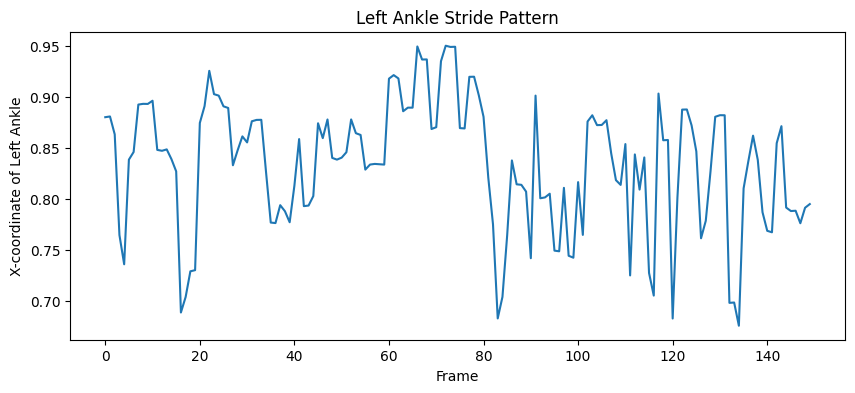

Average Stride Length: 0.05 units (e.g., pixels)


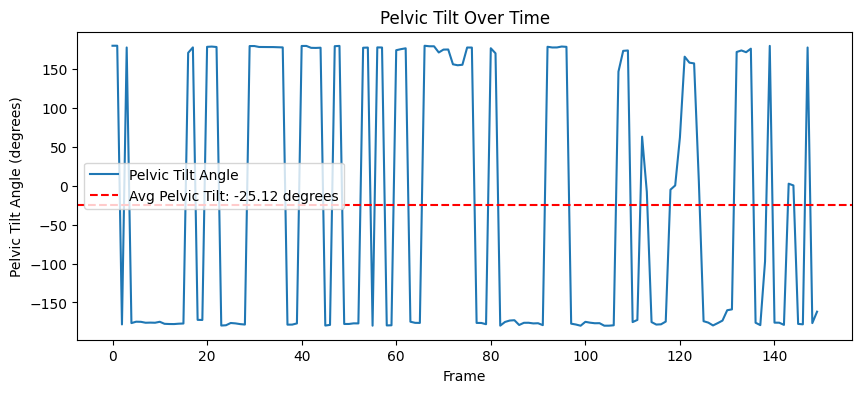

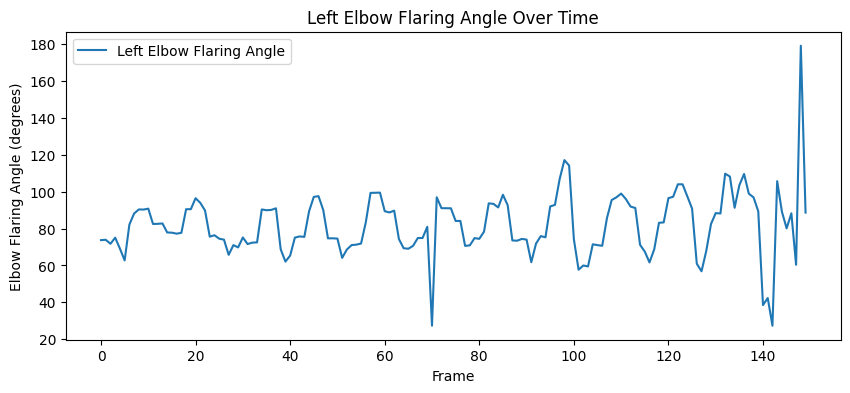

Average Left Elbow Flaring Angle: 81.86 degrees


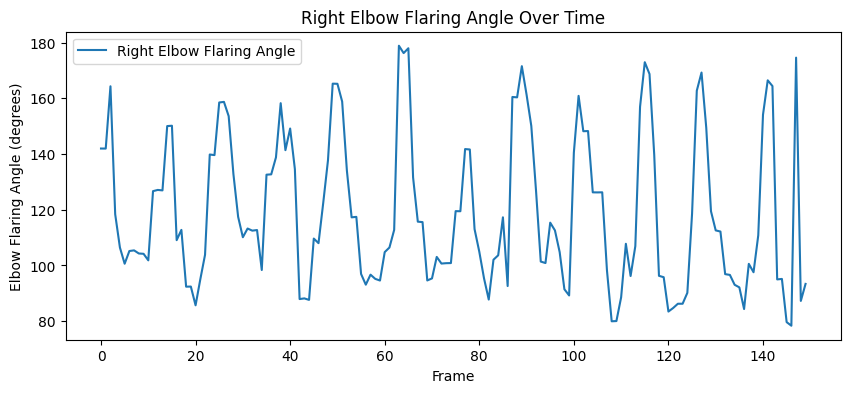

Average Right Elbow Flaring Angle: 119.19 degrees


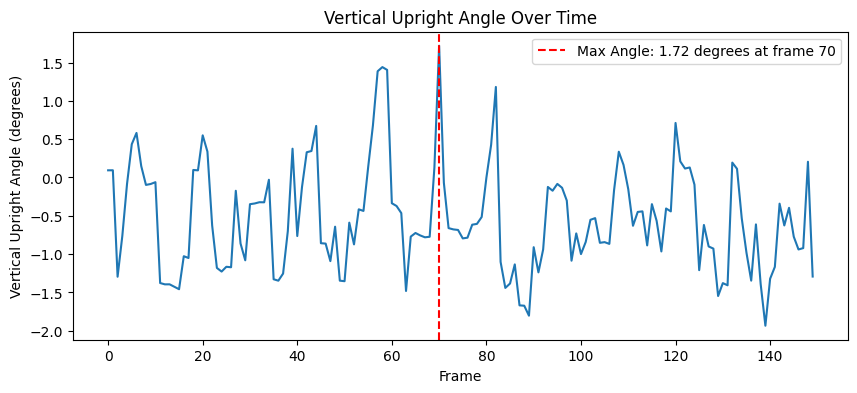

In [14]:
process_video()